# STAT 453 Fall 2025 — HW4
Dataset: **Fashion‑MNIST** (auto‑downloads).

We recommend Colab.

Make sure you are using GPU for training! In Colab:
> Select Runtime > Change runtime type > GPU (T4)


## Contents
- [0. Setup & Utilities](#0)
- [1. Autoencoder](#1)
  - [A. MLP (25 pts)](#1B)
  - [A. Convolutional (25 pts)](#1B)
  - [C. Upsampling (25pts) ](#1C)
  - [D. Latent dimensionality (25pts) ](#1D)
- [2. Bonus: GAN (+50 pts)](#2)

## 0. Setup & Utilities

In [4]:
# Don't change this install and setup code, just run the cell.
print("Installing dependencies...", end='')
!pip -q install scikit-image umap-learn

import sys, platform, random, math, time, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.utils import spectral_norm
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 123
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
print("Finished installing dependencies.")
print({
    "seed": seed,
    "python": sys.version.split()[0],
    "os": platform.platform(),
    "pytorch": torch.__version__,
    "cuda_available": torch.cuda.is_available()
})

# Data loaders (Fashion-MNIST)
BATCH = 128

tf_01   = transforms.Compose([transforms.ToTensor()])  # [0,1] for sigmoid+BCE
tf_tanh = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*2-1)])  # [-1,1] for tanh/MSE

print("Loading data...", end='')
train_ds_01 = tv.datasets.FashionMNIST(root="./data", train=True,  download=True, transform=tf_01)
test_ds_01  = tv.datasets.FashionMNIST(root="./data", train=False, download=True, transform=tf_01)

train_loader_01 = DataLoader(train_ds_01, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader_01  = DataLoader(test_ds_01,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# We'll also keep a tanh-scaled variant for A4 (output scaling study)
train_ds_tanh = tv.datasets.FashionMNIST(root="./data", train=True,  download=True, transform=tf_tanh)
test_ds_tanh  = tv.datasets.FashionMNIST(root="./data", train=False, download=True, transform=tf_tanh)
train_loader_tanh = DataLoader(train_ds_tanh, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader_tanh  = DataLoader(test_ds_tanh,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
print("Finished loading data.")
print("Device:", device, "| Train batches:", len(train_loader_01))

# Plotting helper functions
def show_grid(imgs, nrow=10, title=None):
    grid = tv.utils.make_grid(imgs.cpu()[:nrow*nrow], nrow=nrow, padding=2, normalize=True, value_range=(0,1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

def recon_grid(x, xr, n=10, title=None):
    x = x[:n*n].cpu()
    xr = xr[:n*n].cpu()
    interleaved = torch.stack([x, xr], dim=1).reshape(-1, *x.shape[1:])
    show_grid(interleaved, nrow=2, title=title)

def psnr_ssim_batch(x, xr, scale="[0,1]"):
    if scale=="[-1,1]":
        x, xr = (x+1)/2, (xr+1)/2
    xnp, xrnp = x.detach().cpu().numpy(), xr.detach().cpu().numpy()
    P, S = [], []
    for i in range(min(64, xnp.shape[0])):
        P.append(PSNR(xnp[i,0], xrnp[i,0], data_range=1.0))
        S.append(SSIM(xnp[i,0], xrnp[i,0], data_range=1.0))
    return float(np.mean(P)), float(np.mean(S))

Installing dependencies...Finished installing dependencies.
{'seed': 123, 'python': '3.12.12', 'os': 'Linux-6.6.105+-x86_64-with-glibc2.35', 'pytorch': '2.8.0+cu126', 'cuda_available': True}
Loading data...Finished loading data.
Device: cuda | Train batches: 469


<a id="1"></a>

## 1. Exploring Autoencoders

In [5]:
# Helper functions for training the AE.
# Don't change these.
def train_ae(model, loader, epochs=5, lr=1e-3, loss_type="bce", scale="01"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    model.train()
    for ep in range(1, epochs+1):
        ep_loss = 0.0
        for x, _ in loader:
            x = x.to(device)
            xr, _ = model(x)
            if loss_type=="bce":
                loss = F.binary_cross_entropy(xr, x)
            else:
                loss = F.mse_loss(xr, x)
            opt.zero_grad(); loss.backward(); opt.step()
            ep_loss += loss.item()*x.size(0)
        ep_loss /= len(loader.dataset)
        losses.append(ep_loss)
        print(f"[AE] epoch {ep}/{epochs} loss={ep_loss:.4f}")
    return losses

def eval_recon_metrics(model, loader, scale="01"):
    model.eval()
    xs, xrs = [], []
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            xr, _ = model(x)
            xs.append(x); xrs.append(xr)
            if len(xs)*x.size(0) >= 512: break
    x = torch.cat(xs); xr = torch.cat(xrs)
    if scale=="tanh":
        # Rescale to [0,1] for metrics
        x01 = (x+1)/2; xr01 = (xr+1)/2
    else:
        x01, xr01 = x, xr
    # Compute PSNR/SSIM on subset
    xs_np = x01.detach().cpu().numpy()
    xrs_np = xr01.detach().cpu().numpy()
    ps, ss = [], []
    for i in range(min(64, len(xs_np))):
        ps.append(PSNR(xs_np[i,0], xrs_np[i,0], data_range=1.0))
        ss.append(SSIM(xs_np[i,0], xrs_np[i,0], data_range=1.0))
    return float(np.mean(ps)), float(np.mean(ss)), (x01, xr01)

def training_run(encoder_factory, decoder_factory, model_name, z_dim=32):
  # Train the AE.
  ae = AE(encoder_factory, decoder_factory, z_dim=z_dim, out_act="sigmoid")
  ae_losses = train_ae(ae, train_loader_01, epochs=5, lr=1e-3, loss_type="bce", scale="01")
  ps, ss, (xb, xrb) = eval_recon_metrics(ae, test_loader_01, scale="01")
  print("Baseline PSNR=%.3f SSIM=%.3f" % (ps, ss))
  recon_grid(xb, xrb, title="Baseline ConvAE (deconv) — input vs recon")
  plt.figure()
  plt.plot(ae_losses)
  plt.title("AE train loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

<a id="1B"></a>
### 1A. MLP Autoencoder

In [6]:
class MLPEnc(nn.Module):
    def __init__(self, z_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(True),
            nn.Linear(512, 256),   nn.ReLU(True),
            nn.Linear(256, z_dim)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

class MLPDec(nn.Module):
    def __init__(self, z_dim=32, out_act="sigmoid"):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(True),
            nn.Linear(256, 512),   nn.ReLU(True),
            nn.Linear(512, 28*28),
        )
        self.out_act = out_act
    def forward(self, z):
        x = self.net(z).view(-1,1,28,28)
        return torch.sigmoid(x) if self.out_act=="sigmoid" else torch.tanh(x)

class AE(nn.Module):
    def __init__(self, encoder_factory, decoder_factory, z_dim=32, out_act="sigmoid"):
        super().__init__()
        self.enc = encoder_factory(z_dim)
        self.dec = decoder_factory(z_dim, out_act=out_act)
    def forward(self, x):
        # =================
        # Students fill in here
        z  = self.enc(x)
        xr = self.dec(z)
        # =================
        return xr, z

[AE] epoch 1/5 loss=0.3412
[AE] epoch 2/5 loss=0.2964
[AE] epoch 3/5 loss=0.2887
[AE] epoch 4/5 loss=0.2839
[AE] epoch 5/5 loss=0.2805
Baseline PSNR=19.934 SSIM=0.724


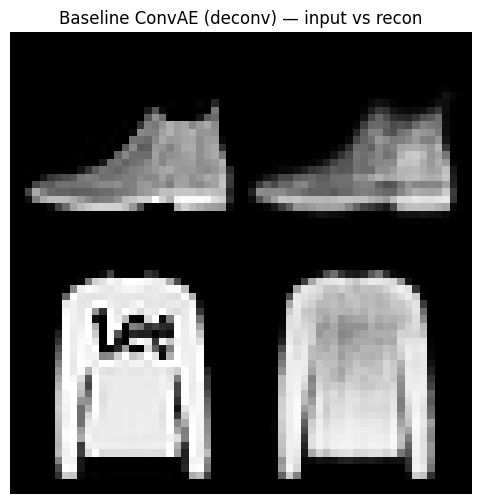

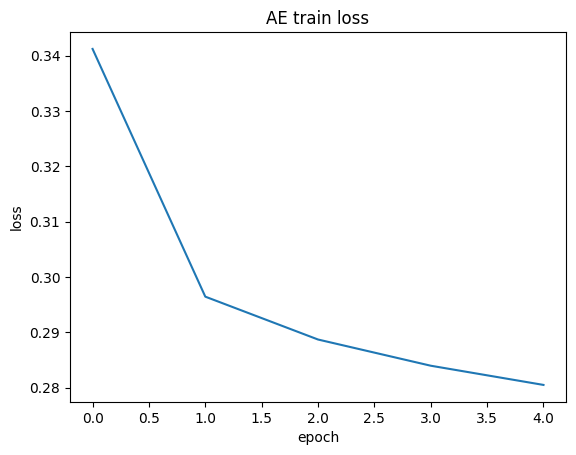

In [7]:
# Train the AutoEncoder. Don't change this, just run it. It should use the modules you finished above.
training_run(MLPEnc, MLPDec, "MLP AE", 32)

<a id="1B"></a>

### 1B. Convolutional AE

Let's use convolutions in our encoder, and "de-convolutions" in our decoder.
You fill in the shapes below.

In [8]:
class ConvEncoder(nn.Module):
    def __init__(self, z_dim=32):
        super().__init__()
        # =================
        # Students fill in here.
        # Replace Nones with correct dimensionalities.
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True),
        )
        self.fc = nn.Linear(128*7*7, z_dim)
        # =================
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z

class DecoderConvT(nn.Module):
    # Decoder using ConvTranspose (deconv)
    def __init__(self, z_dim=32, out_act="sigmoid"):
        super().__init__()
        self.fc = nn.Linear(z_dim, 128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),  # 7 -> 14
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),   # 14 -> 28
            nn.Conv2d(32, 1, 3, 1, 1),
        )
        self.out_act = out_act
    def forward(self, z):
        h = self.fc(z).view(-1, 128, 7, 7)
        x = self.deconv(h)
        if self.out_act == "sigmoid": x = torch.sigmoid(x)
        elif self.out_act == "tanh": x = torch.tanh(x)
        return x

[AE] epoch 1/5 loss=0.3216
[AE] epoch 2/5 loss=0.2780
[AE] epoch 3/5 loss=0.2709
[AE] epoch 4/5 loss=0.2673
[AE] epoch 5/5 loss=0.2653
Baseline PSNR=22.162 SSIM=0.811


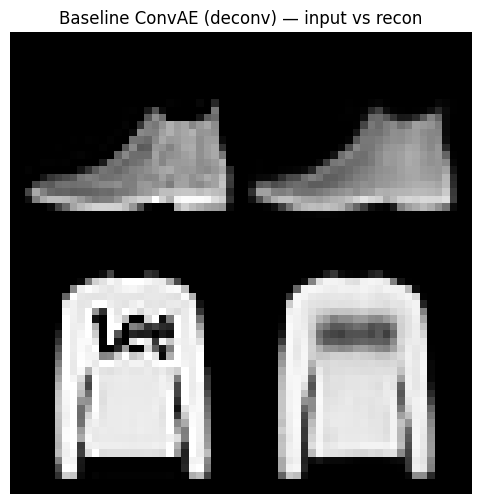

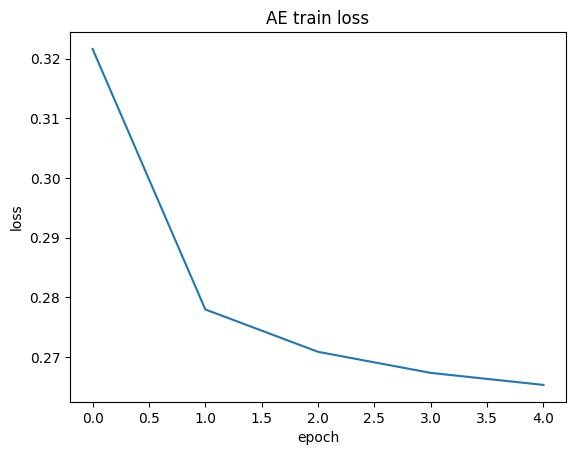

In [9]:
training_run(ConvEncoder, DecoderConvT, "Convolutional AE", 32)

<a id="1C"></a>

### 1C. Decoder ablation — Should we upsample?

Let's define upsampling in our decoder. You fill in the module below.

In [10]:
class DecoderUpConv(nn.Module):
    # Decoder using nearest upsample + Conv (often fewer artifacts)
    def __init__(self, z_dim=32, out_act="sigmoid"):
        super().__init__()
        self.fc = nn.Linear(z_dim, 128*7*7)
        # =================
        # Students fill in here.
        # Replace Nones with correct dimensionalities.
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            # nn.Upsample takes a tensor of shape [N, C, H, W] to [N, C, 2H, 2W]
            nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, 1, 3, 1, 1)
        )
        # =================
        self.out_act = out_act
    def forward(self, z):
        h = self.fc(z).view(-1, 128, 7, 7)
        x = self.net(h)
        if self.out_act == "sigmoid": x = torch.sigmoid(x)
        elif self.out_act == "tanh": x = torch.tanh(x)
        return x

[AE] epoch 1/5 loss=0.3139
[AE] epoch 2/5 loss=0.2732
[AE] epoch 3/5 loss=0.2677
[AE] epoch 4/5 loss=0.2653
[AE] epoch 5/5 loss=0.2638
Baseline PSNR=22.331 SSIM=0.817


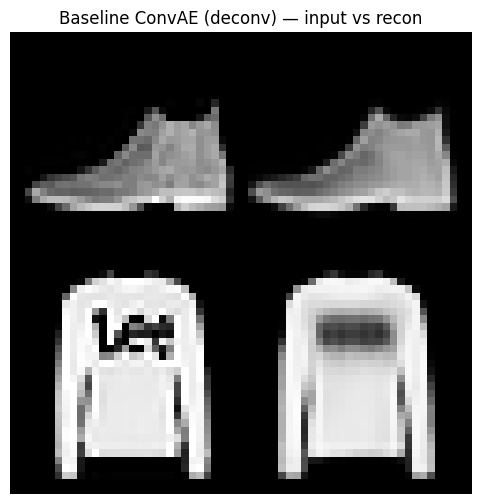

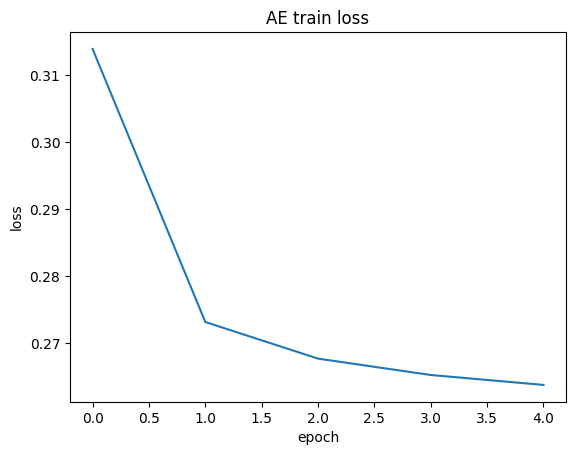

In [11]:
# Train the decoder with up-sampling.
training_run(ConvEncoder, DecoderUpConv, "Convolutional AE with Up-Sampling", 32)

<a id="1D"></a>

### 1D. Latent dimensionality sweep (z ∈ {8,16,32,64})

Run the cells with the experiments, and fill in the answers to the 2 questions below.

[AE] epoch 1/3 loss=0.3273
[AE] epoch 2/3 loss=0.2892
[AE] epoch 3/3 loss=0.2851
z=8  PSNR=19.415  SSIM=0.706
[AE] epoch 1/3 loss=0.3154
[AE] epoch 2/3 loss=0.2788
[AE] epoch 3/3 loss=0.2743
z=16  PSNR=20.732  SSIM=0.764
[AE] epoch 1/3 loss=0.3172
[AE] epoch 2/3 loss=0.2727
[AE] epoch 3/3 loss=0.2672
z=32  PSNR=21.898  SSIM=0.801
[AE] epoch 1/3 loss=0.3088
[AE] epoch 2/3 loss=0.2693
[AE] epoch 3/3 loss=0.2634
z=64  PSNR=22.724  SSIM=0.827


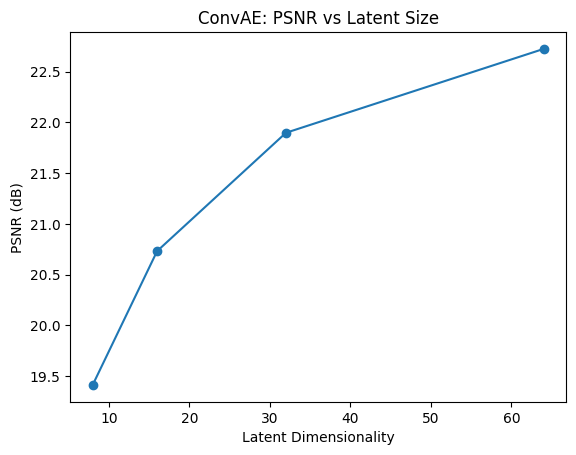

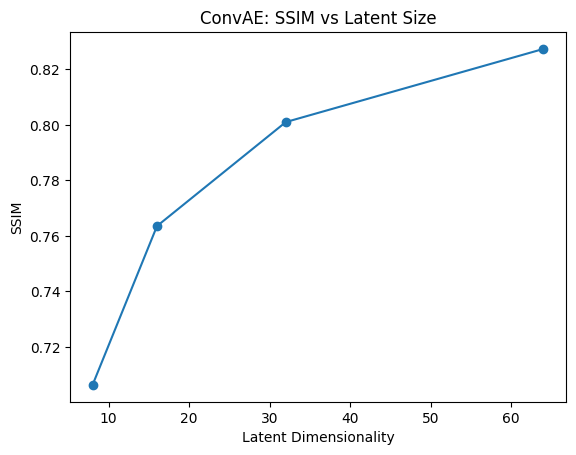

Latent dimensionality 8


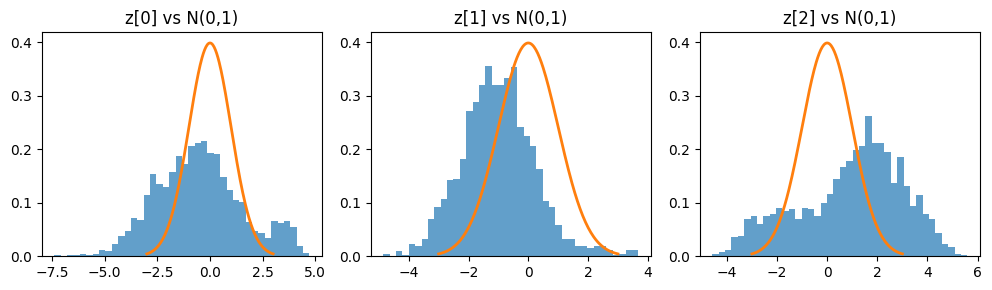

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


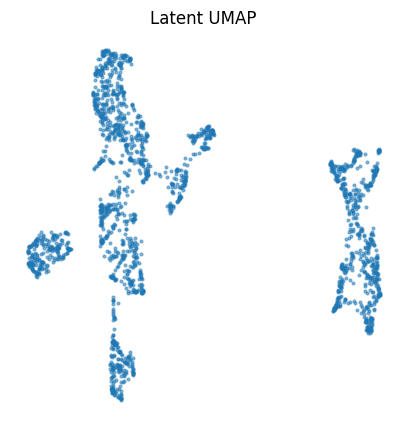

Latent dimensionality 16


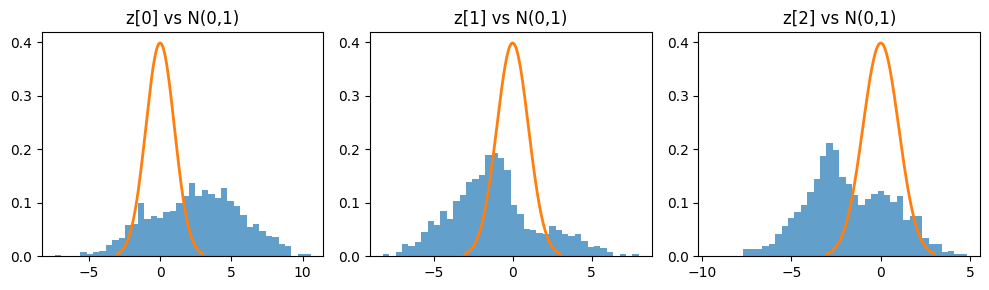

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


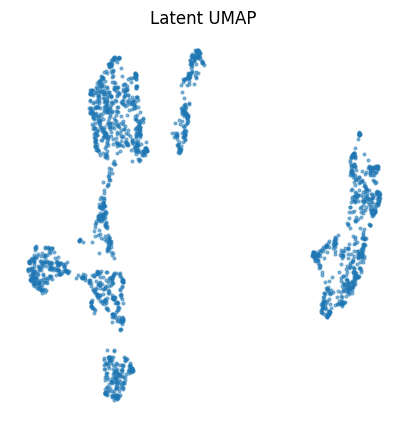

Latent dimensionality 32


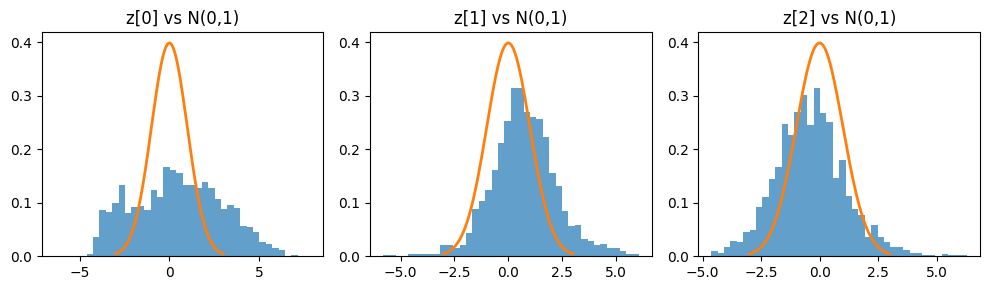

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


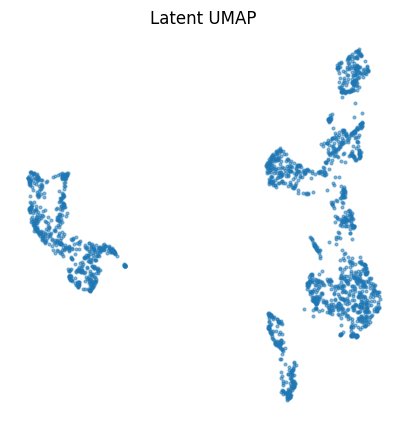

Latent dimensionality 64


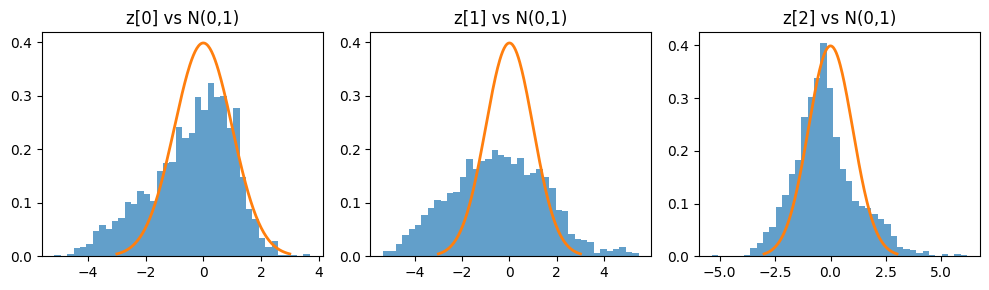

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


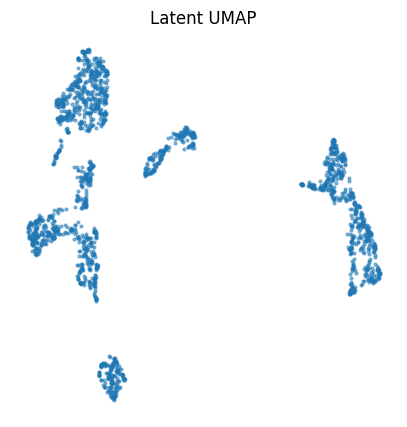

In [12]:
def sweep_latent(
    encoder_cls=ConvEncoder,
    decoder_cls=DecoderUpConv,
    z_list=(8, 16, 32, 64),
    epochs=3,
    loader_train=train_loader_01,
    loader_test=test_loader_01,
    scale="01",
    lr=1e-3,
):
    """Train AEs over z_list and return results + models."""
    results, models = [], []
    for z in z_list:
        model = AE(encoder_cls, decoder_cls, z_dim=z, out_act="sigmoid").to(device)
        train_ae(model, loader_train, epochs=epochs, lr=lr, loss_type="bce", scale=scale)
        p, s, _ = eval_recon_metrics(model, loader_test, scale=scale)
        results.append({"z": z, "psnr": p, "ssim": s})
        models.append(model)
        print(f"z={z}  PSNR={p:.3f}  SSIM={s:.3f}")
    return results, models


def plot_sweep(results, title_prefix="AE"):
    zs   = [r["z"] for r in results]
    psnr = [r["psnr"] for r in results]
    ssim = [r["ssim"] for r in results]

    plt.figure(); plt.plot(zs, psnr, marker="o")
    plt.title(f"{title_prefix}: PSNR vs Latent Size")
    plt.xlabel("Latent Dimensionality"); plt.ylabel("PSNR (dB)"); plt.show()

    plt.figure(); plt.plot(zs, ssim, marker="o")
    plt.title(f"{title_prefix}: SSIM vs Latent Size")
    plt.xlabel("Latent Dimensionality"); plt.ylabel("SSIM"); plt.show()


@torch.no_grad()
def collect_latents(model, loader, n=2000):
    """Collect up to n latent codes from model on loader."""
    out, seen = [], 0
    for x, _ in loader:
        x = x.to(device)
        _, z = model(x)
        out.append(z.cpu())
        seen += x.size(0)
        if seen >= n: break
    return torch.cat(out, dim=0)[:n]


def visualize_latents(models, zs, loader=test_loader_01, n=2000, random_state=0):
    """For each (z_dim, model) pair: hist overlay for first 3 dims + UMAP."""
    import umap
    for z_dim, model in zip(zs, models):
        print(f"Latent dimensionality {z_dim}")
        Z = collect_latents(model, loader, n=n).numpy()

        # per-dim hist vs N(0,1) for first 3 dims
        plt.figure(figsize=(10, 3))
        xs = np.linspace(-3, 3, 200)
        std_norm = 1/np.sqrt(2*np.pi)*np.exp(-xs**2/2)
        for d in range(min(3, Z.shape[1])):
            plt.subplot(1, 3, d+1)
            plt.hist(Z[:, d], bins=40, density=True, alpha=0.7)
            plt.plot(xs, std_norm, lw=2)
            plt.title(f"z[{d}] vs N(0,1)")
        plt.tight_layout(); plt.show()

        # UMAP view
        emb = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_state).fit_transform(Z)
        plt.figure(figsize=(5, 5)); plt.scatter(emb[:, 0], emb[:, 1], s=4, alpha=0.5)
        plt.title("Latent UMAP"); plt.axis("off"); plt.show()

results, models = sweep_latent(encoder_cls=ConvEncoder, decoder_cls=DecoderUpConv)
plot_sweep(results, title_prefix="ConvAE")
zs = [r["z"] for r in results]
visualize_latents(models, zs)


[AE] epoch 1/3 loss=0.3248
[AE] epoch 2/3 loss=0.2888
[AE] epoch 3/3 loss=0.2848
z=8 Peak Signal-to-Noise Ratio=19.427 Structural Similarity=0.712
[AE] epoch 1/3 loss=0.3156
[AE] epoch 2/3 loss=0.2784
[AE] epoch 3/3 loss=0.2741
z=16 Peak Signal-to-Noise Ratio=20.677 Structural Similarity=0.761
[AE] epoch 1/3 loss=0.3151
[AE] epoch 2/3 loss=0.2736
[AE] epoch 3/3 loss=0.2677
z=32 Peak Signal-to-Noise Ratio=21.679 Structural Similarity=0.801
[AE] epoch 1/3 loss=0.3106
[AE] epoch 2/3 loss=0.2693
[AE] epoch 3/3 loss=0.2636
z=64 Peak Signal-to-Noise Ratio=22.620 Structural Similarity=0.829


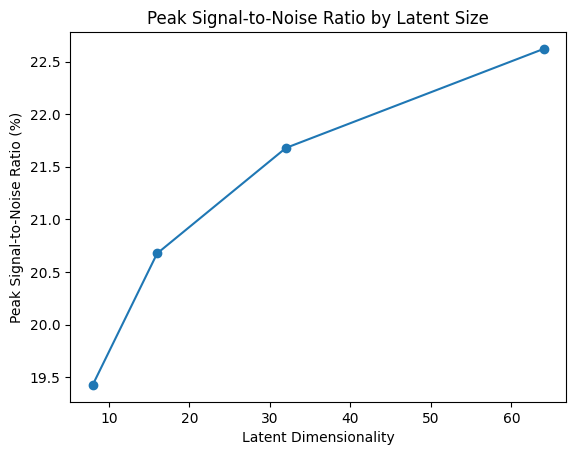

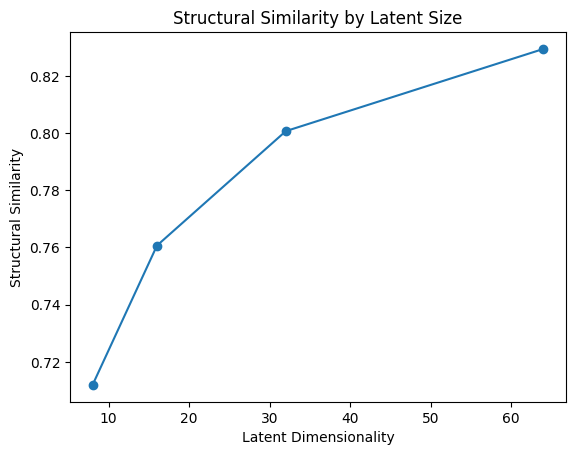

Latent dimensionality 8


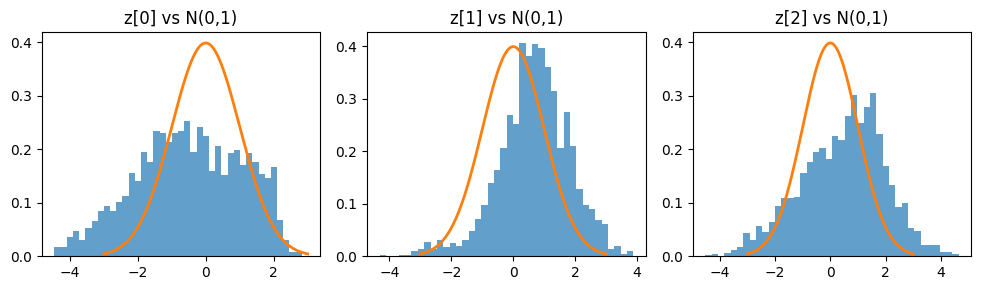

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


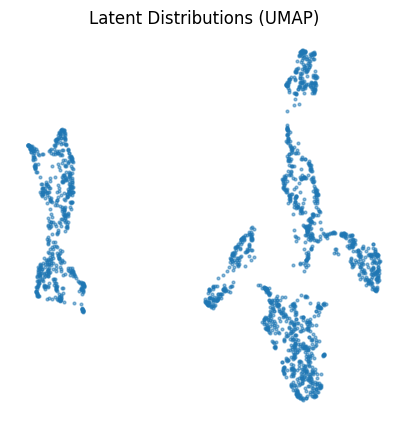

Latent dimensionality 16


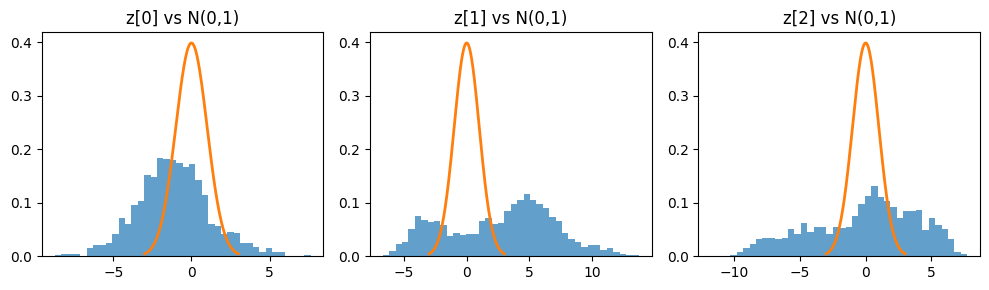

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


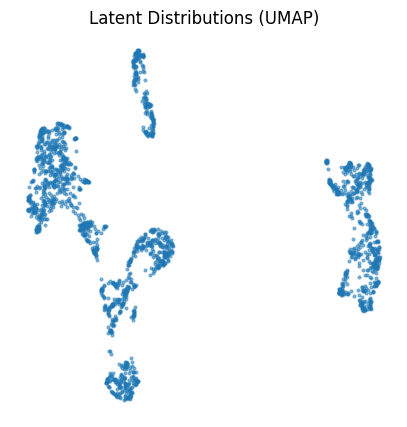

Latent dimensionality 32


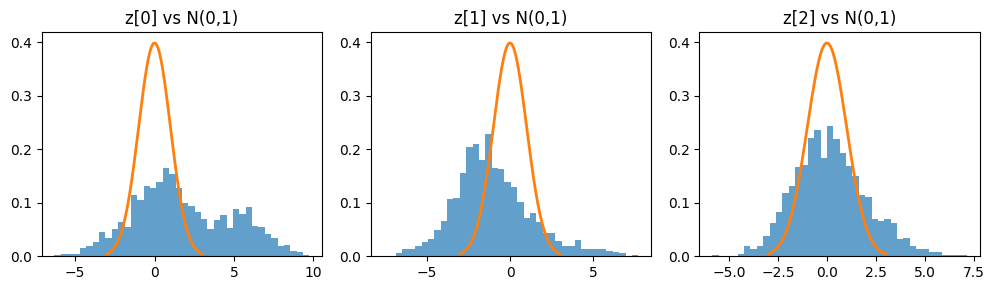

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


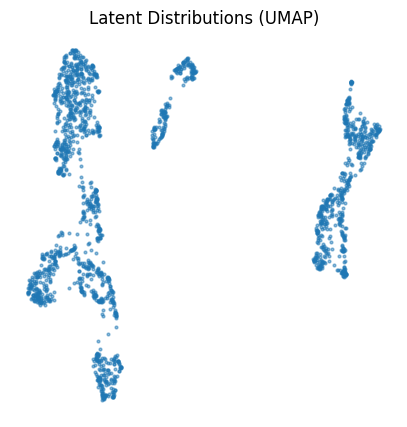

Latent dimensionality 64


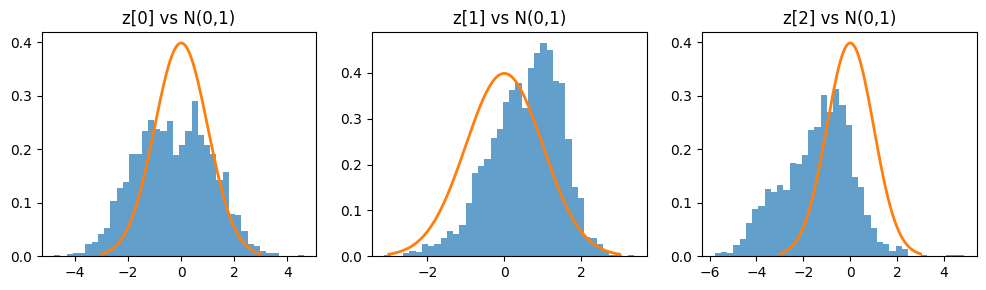

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


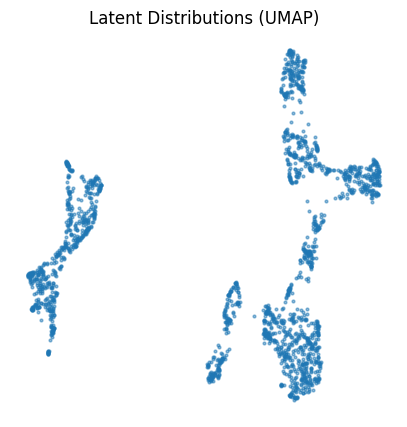

In [13]:
def sweep_latent(encoder_type=ConvEncoder, decoder_type=DecoderUpConv, z_list=(8,16,32,64), epochs=3):
    results = []
    for z in z_list:
        m = AE(encoder_type, decoder_type, z_dim=z, out_act="sigmoid").to(device)
        _ = train_ae(m, train_loader_01, epochs=epochs, lr=1e-3, loss_type="bce", scale="01")
        p, s, _ = eval_recon_metrics(m, test_loader_01, scale="01")
        results.append({"m": m, "z": z, "p": p, "s": s})
        print(f"z={z} Peak Signal-to-Noise Ratio={p:.3f} Structural Similarity={s:.3f}")
    return results

latent_results = sweep_latent()
zs = [r["z"] for r in latent_results]
psnrs = [r["p"] for r in latent_results]
ssims = [r["s"] for r in latent_results]
models = [r["m"] for r in latent_results]
plt.figure(); plt.plot(zs, psnrs, marker="o"); plt.title("Peak Signal-to-Noise Ratio by Latent Size"); plt.xlabel("Latent Dimensionality"); plt.ylabel("Peak Signal-to-Noise Ratio (%)"); plt.show()
plt.figure(); plt.plot(zs, ssims, marker="o"); plt.title("Structural Similarity by Latent Size"); plt.xlabel("Latent Dimensionality"); plt.ylabel("Structural Similarity"); plt.show()

# Latent fit checks: per-dim histogram overlay vs N(0,1) and 2D UMAP
@torch.no_grad()
def collect_latents(AE, loader, n=2000):
    zs = []
    c = 0
    for x,y in loader:
        x = x.to(device); _, z = AE(x)
        zs.append(z.cpu()); c += len(x)
        if c >= n: break
    return torch.cat(zs)[:n]

for z, model in zip(zs, models):
  print(f"Latent dimensionality {z}")
  Z = collect_latents(model, test_loader_01, n=2000).numpy()
  plt.figure(figsize=(10,3))
  for d in range(min(3, Z.shape[1])):
      plt.subplot(1,3,d+1); plt.hist(Z[:,d], bins=40, density=True, alpha=0.7)
      xs = np.linspace(-3,3,200); plt.plot(xs, 1/np.sqrt(2*np.pi)*np.exp(-xs**2/2), lw=2)
      plt.title(f"z[{d}] vs N(0,1)")
  plt.tight_layout(); plt.show()

  emb = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0).fit_transform(Z)
  plt.figure(figsize=(5,5)); plt.scatter(emb[:,0], emb[:,1], s=4, alpha=0.5)
  plt.title("Latent Distributions (UMAP)"); plt.axis("off"); plt.show()


### Based on the above experiment, what latent dimensionality would you pick?

If limited computing resource, I would pick 32. There is a steep improvement from 8 to 16 and 16 to 32 in PSNR and SSIM. But the curve starts to decrease its slope from 32 to 64 and not increase the efficiency a lot. 32 offers the best trade-off. But if given enough computing resource, 64 is still a good choice since it yeilds the highest performance in PSNR and SSIM.

### What should we do to make the latent distribution match a Normal more closely?

Use a Variational Autoencoder. The current histograms does not strictly follow the Normal distribution patterns. A VAE solves this by adding a KL-Divergence regularization term to force the z in $N(0, 1)$.

<a id="2"></a>

## 2. GAN
Let's train a little GAN on this same dataset.
You fill in the loss functions inside the training pipeline.

In [14]:
# Don't edit these modules.
class G_CNN(nn.Module):
    def __init__(self, z_dim=100, ngf=64):
        super().__init__()
        self.fc = nn.Linear(z_dim, ngf*4*7*7)  # 256*7*7 if ngf=64
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),       # 7->14
            nn.Conv2d(ngf*4, ngf*2, 3, 1, 1), nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode="nearest"),       # 14->28
            nn.Conv2d(ngf*2, ngf, 3, 1, 1), nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.Conv2d(ngf, 1, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z):
        h = self.fc(z).view(-1, 256, 7, 7)
        return self.up(h)

class D_CNN(nn.Module):
    def __init__(self, spectral=False, ndf=64):
        super().__init__()
        Conv = lambda c_in,c_out,k,s,p: spectral_norm(nn.Conv2d(c_in,c_out,k,s,p)) if spectral else nn.Conv2d(c_in,c_out,k,s,p)
        self.net = nn.Sequential(
            Conv(1,   ndf,   4, 2, 1), nn.LeakyReLU(0.2, True),   # 28->14
            Conv(ndf, ndf*2, 4, 2, 1), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, True),  # 14->7
            Conv(ndf*2, ndf*4, 3, 1, 1), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, True),
        )
        self.fc = nn.Linear(ndf*4*7*7, 1)
    def forward(self, x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        return self.fc(h).squeeze(-1)

[GAN-CNN] step 500/2000  d=1.089  g=0.755
[GAN-CNN] step 1000/2000  d=0.999  g=1.375
[GAN-CNN] step 1500/2000  d=0.979  g=1.047
[GAN-CNN] step 2000/2000  d=1.029  g=0.927


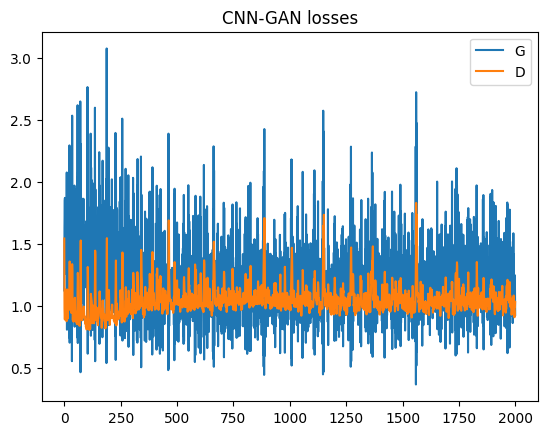

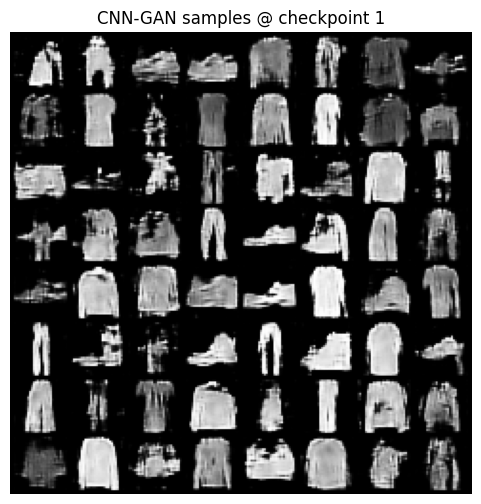

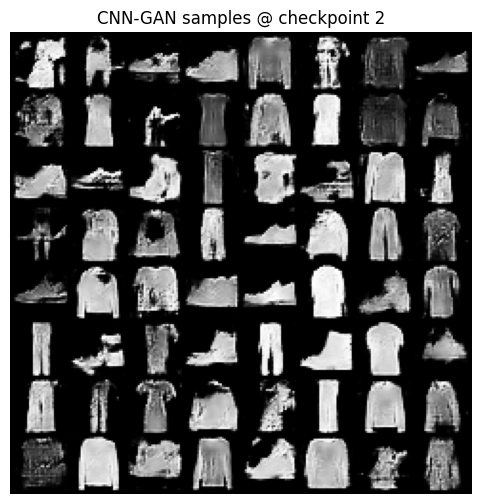

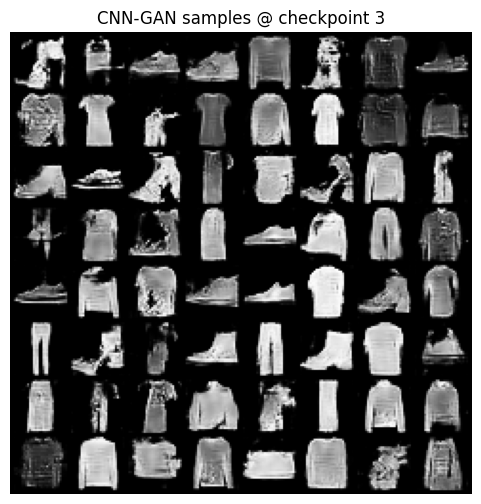

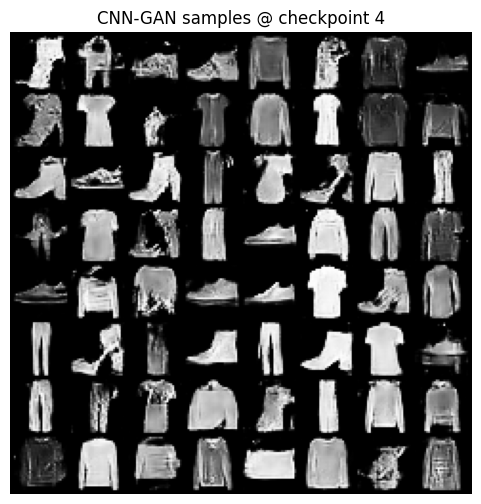

In [15]:
def train_gan_cnn(steps=3000, z_dim=100, lr_g=2e-4, lr_d=2e-4, betas=(0.5,0.999),
                  label_smooth=True, ttur=False, spectral=False, log_every=300):
    G = G_CNN(z_dim).to(device)
    D = D_CNN(spectral=spectral).to(device)
    if ttur:
        opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=betas)
        opt_d = torch.optim.Adam(D.parameters(), lr=lr_d*2.0, betas=betas)
    else:
        opt_g = torch.optim.Adam(G.parameters(), lr=lr_g, betas=betas)
        opt_d = torch.optim.Adam(D.parameters(), lr=lr_d, betas=betas)

    real_label = 0.9 if label_smooth else 1.0
    fake_label = 0.1 if label_smooth else 0.0
    fixed_z = torch.randn(64, z_dim, device=device)
    g_losses, d_losses, samples = [], [], []

    data_iter = iter(train_loader_01)
    for step in range(1, steps+1):
        try:
            x,_ = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader_01)
            x,_ = next(data_iter)
        x = (x*2-1).to(device)  # scale to [-1,1]

        # D update
        z = torch.randn(x.size(0), z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        D_real = D(x)
        D_fake = D(x_fake)
        # ===================
        # Students fill in here.
        # Calculate the loss of the discriminator.
        # Hint: use F.binary_cross_entropy_with_logits
        d_loss = F.binary_cross_entropy_with_logits(D_real, torch.full_like(D_real, real_label)) + F.binary_cross_entropy_with_logits(D_fake, torch.full_like(D_fake, fake_label))
        # ===================
        opt_d.zero_grad(); d_loss.backward(); opt_d.step()

        # G update
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G(z)
        D_fake = D(x_fake)
        # ===================
        # Students fill in here.
        # Calculate the loss of the generator.
        # Hint: use F.binary_cross_entropy_with_logits
        g_loss = F.binary_cross_entropy_with_logits(D_fake, torch.full_like(D_fake, real_label))
        # ===================
        opt_g.zero_grad(); g_loss.backward(); opt_g.step()

        g_losses.append(g_loss.item()); d_losses.append(d_loss.item())

        if step % log_every == 0:
            with torch.no_grad():
                samp = (G(fixed_z)+1)/2
            samples.append(samp.cpu())
            print(f"[GAN-CNN] step {step}/{steps}  d={d_loss.item():.3f}  g={g_loss.item():.3f}")
    return G, D, (g_losses, d_losses, samples)

# Baseline CNN GAN
G, D, logs = train_gan_cnn(steps=2000, label_smooth=True, spectral=False, ttur=False, log_every=500)
g_losses, d_losses, samples = logs
plt.figure(); plt.plot(g_losses, label="G"); plt.plot(d_losses, label="D"); plt.legend(); plt.title("CNN-GAN losses"); plt.show()
for i, s in enumerate(samples):
    show_grid(s, nrow=8, title=f"CNN-GAN samples @ checkpoint {i+1}")